<a href="https://colab.research.google.com/github/hrnrhty/my-vae-nnabla/blob/main/step2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 2 - 入力画像と VAE 生成画像の比較

Step 2 では、Step 1 で学習した結果を用いて VAE (Variational Auto Encoder) の推論を実行します。VAE で推論を実行すると画像が生成されます。生成された画像が入力画像と比較してどのように違うのか、実際に画像を表示して確認していきます。

なお、このステップを実行するには Step 1 の学習結果が必須です。まだ Step 1 を実行していない場合は、先に Step 1 を最後まで実行して学習結果を準備してください。Step 1 のノートブックは以下のバナーから開くことができます。  
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hrnrhty/my-vae-nnabla/blob/main/step1.ipynb)

また、推論は学習に比べて処理に時間がかからないため、このステップでは GPU アクセラレーションを使用せず、CPU のみで処理を実行していきます。

## Google Drive のマウント

Step 1 の学習結果を読み込むため Google Drive をマウントします。

> Note: 先に Step 1 を最後まで実行しておいてください。

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## NNabla のインストール

本ステップでは GPU アクセラレーションを使用しないので、通常の [NNabla](https://github.com/sony/nnabla) だけをインストールします（CUDA 版はインストールしません）。

ここでは、2022 年 2 月 2 日時点、最新バージョンである v1.25.0 をインストールしますが、おもむろにインストールを実行すると `pip` コマンドの実行結果の中にエラーメッセージが表示されます。依存パッケージの中に、Google Colab のランタイムにはじめからインストールされているものがあり、そのバージョンが NNabla の要求するバージョンよりも新しいバージョンであることが原因です。

エラーが表示されても NNabla のインストールに成功していれば以降のコードは問題なく実行できることがほとんどですが、ここでは NNabla が要求するバージョンのパッケージを手動インストールすることによりエラーを回避します。

下記、1 行目のコマンドは NNabla の依存パッケージの一部をバージョン指定でインストールします。2 行目のコマンドは NNabla をインストールします。

どのようなエラーメッセージが表示されるのか気になる方は、1 行目をコメントアウトして実行してみてください。一度実行済の場合は、Google Colab のランタイムを出荷設定にリセットしてから実行してください。

In [2]:
!pip install urllib3==1.25.11 folium==0.2.1
!pip install nnabla==1.25.0

     |████████████████████████████████| 127 kB 14.1 MB/s 
     |████████████████████████████████| 69 kB 7.0 MB/s 
  Created wheel for folium: filename=folium-0.2.1-py3-none-any.whl size=79808 sha256=08175c9ed2aa64d07e4796035e240dcebf5faee8cb514c9d1979530cfe024fab
  Stored in directory: /root/.cache/pip/wheels/9a/f0/3a/3f79a6914ff5affaf50cabad60c9f4d565283283c97f0bdccf
Successfully built folium
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: folium
    Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3
     |████████████████████████████████| 18.1 MB 935 kB/s 
     |████████████████████████████████| 132 kB 49.7 MB/s 
     |████████████████████████████████| 79 kB 6.4 MB/s 
     |████████████████████████████████| 8.6 MB 50.2 MB/s 


## nnabla-examples のクローン

Step 1 同様、[nnabla-examples](https://github.com/sony/nnabla-examples) v1.25.0 をクローンします。

In [3]:
!if [ -d nnabla-examples ]; then rm -rf nnabla-examples; fi
!git clone https://github.com/sony/nnabla-examples.git -b v1.25.0 --depth 1

Cloning into 'nnabla-examples'...
remote: Enumerating objects: 1557, done.
remote: Counting objects: 100% (1557/1557), done.
remote: Compressing objects: 100% (1408/1408), done.
remote: Total 1557 (delta 241), reused 884 (delta 82), pack-reused 0
Receiving objects: 100% (1557/1557), 201.62 MiB | 22.41 MiB/s, done.
Resolving deltas: 100% (241/241), done.
Note: checking out '03b674a19e8289ce870cd3dfd2a0983d6ef004fc'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

Checking out files: 100% (1377/1377), done.


## VAE 関数の読み込み

[nnabla-examples](https://github.com/sony/nnabla-examples) の `vae.py` およびその他 Helper 関数を利用するため、カレントディレクトリを移動します。

In [4]:
%cd 'nnabla-examples/image-classification/mnist-collection'

/content/nnabla-examples/image-classification/mnist-collection


`vae.py` 内で提供されている関数 `vae` は `loss` しか返しません。そこで、推論結果も返すように `vae.py` を書き換えます。

In [5]:
!sed -i -e 's/return loss/return loss, prob/g' vae.py

推論結果 `prob` も返すように改造した関数 `vae` をインポートします。

In [6]:
from vae import vae

2022-03-23 09:30:26,690 [nnabla][INFO]: Initializing CPU extension...


## 学習結果の読み込み

後ほど使用する module も含め、ここでまとめてインポートします。

In [7]:
import nnabla as nn
import nnabla.functions as F
from mnist_data import data_iterator_mnist

Step 1 で保存した学習済みパラメータを読み込みます。

In [8]:
_ = nn.load_parameters('/content/drive/MyDrive/my-vae-nnabla/step1/params_060000.h5')

## 推論の実行

学習済モデルが準備できたので、推論を実行してみます。下記のコードでは、変数 `x` を作成し、[MNIST](http://yann.lecun.com/exdb/mnist/) データセットからランダムに10個の画像を取り出し、`x` に格納しています。そして、関数 `vae` の推論結果に `sigmoid` 関数を適用してデータの値域を (0, 1.0) の区間に正規化し、最終的な推論結果とするよう定義しています。最後の行で `forward()` をコールし、推論を実行しています。

In [9]:
shape_x = (1, 28, 28)
shape_z = (50,)
x = nn.Variable((10,) + shape_x)

loss, prob = vae(x, shape_z, test=True)
di_t = data_iterator_mnist(10, False)
x.d, _ = di_t.next()
prob = F.sigmoid(prob)
prob.forward()

2022-03-23 09:30:30,851 [nnabla][INFO]: DataSource with shuffle(True)
2022-03-23 09:30:30,853 [nnabla][INFO]: Getting label data from http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz.
t10k-labels-idx1-ubyte.gz: 100%|██████████| 4.44k/4.44k [00:00<00:00, 7.50MB/s]
2022-03-23 09:30:30,915 [nnabla][INFO]: Getting label data done.
2022-03-23 09:30:30,918 [nnabla][INFO]: Getting image data from http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz.
t10k-images-idx3-ubyte.gz: 100%|██████████| 1.57M/1.57M [00:00<00:00, 62.8MB/s]
2022-03-23 09:30:31,064 [nnabla][INFO]: Getting image data done.
2022-03-23 09:30:31,071 [nnabla][INFO]: Using DataIterator


GPU アクセラレーションは使用していませんが、あっという間に推論が完了しましたね。

それでは、入力画像とそれに対応する推論結果（生成された画像）を表示してみましょう。ここでは、画像の表示に `matplotlib` を使用します。

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

8 枚目（index = 7）の入力画像を表示してみます。

ここで、入力画像の値域は [0, 255] になっています。このままでも画像の表示はできますが、あとで生成画像と比較するため 256 で割って [0, 1) の区間に正規化します。

In [11]:
img_num = 7

---- 入力画像 ----
Min. value = 0.0
Max. value = 0.99609375


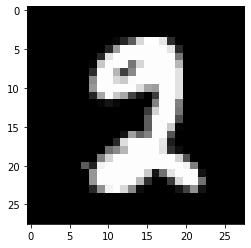

In [12]:
input_img = x.d[img_num][0] / 256.
print('---- 入力画像 ----')
print('Min. value =', input_img.min())
print('Max. value =', input_img.max())
plt.imshow(input_img, cmap='gray')
plt.show()

続いて、推論の結果、VAE が生成した画像を表示してみます。

---- VAE 生成画像 ----
Min. value = 3.6912033e-18
Max. value = 0.9999342


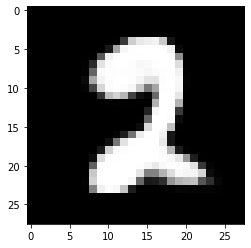

In [13]:
output_img = prob.d[img_num][0]
print('---- VAE 生成画像 ----')
print('Min. value =', output_img.min())
print('Max. value =', output_img.max())
plt.imshow(output_img, cmap='gray')
plt.show()

ちゃんと "2" と判別ができる画像が生成されています！しかしよく見ると、入力画像とは少し異なる点もあるようです。

様々な手書き数字を学習した VAE は、平均的な "2" の生成を試みるようにトレーニングされています。そのため、入力画像に見られた上部の黒い点が消えたり、下部の線の湾曲が直線に近づいたり、全体的に滑らかになった印象があります。

それでは最後に、入力画像と生成画像の差の絶対値をヒートマップ化して、入力画像の上に重ねて表示してみましょう。

---- 入力画像に VAE 生成画像との差分を重畳 ----
Sum of absolute values of difference = 22.96915309392251
Min. diff. (abs) = 3.691203320831118e-18
Max. diff. (abs) = 0.7595529556274414


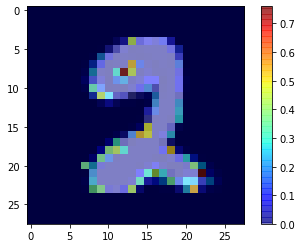

In [14]:
diff = output_img - input_img
abs_diff = abs(diff)
score = sum(sum(abs_diff))
print('---- 入力画像に VAE 生成画像との差分を重畳 ----')
print('Sum of absolute values of difference =', score)
print('Min. diff. (abs) =', abs_diff.min())
print('Max. diff. (abs) =', abs_diff.max())
plt.imshow(input_img, cmap='gray')
diff_img = plt.imshow(abs_diff, cmap='jet', alpha=0.5)
plt.colorbar(diff_img)
plt.show()

他の数字も同様に確認してみましょう。

In [15]:
img_num = 8

---- 入力画像 ----
Min. value = 0.0
Max. value = 0.99609375


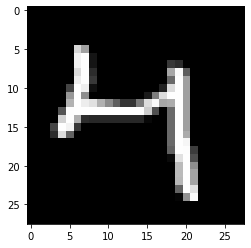

In [16]:
input_img = x.d[img_num][0] / 256.
print('---- 入力画像 ----')
print('Min. value =', input_img.min())
print('Max. value =', input_img.max())
plt.imshow(input_img, cmap='gray')
plt.show()

---- VAE 生成画像 ----
Min. value = 1.03019125e-20
Max. value = 0.9972681


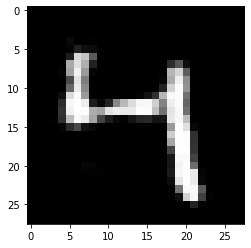

In [17]:
output_img = prob.d[img_num][0]
print('---- VAE 生成画像 ----')
print('Min. value =', output_img.min())
print('Max. value =', output_img.max())
plt.imshow(output_img, cmap='gray')
plt.show()

---- 入力画像に VAE 生成画像との差分を重畳 ----
Sum of absolute values of difference = 28.97674909922073
Min. diff. (abs) = 1.0301912528301411e-20
Max. diff. (abs) = 0.970653060823679


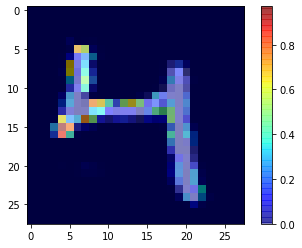

In [18]:
diff = output_img - input_img
abs_diff = abs(diff)
score = sum(sum(abs_diff))
print('---- 入力画像に VAE 生成画像との差分を重畳 ----')
print('Sum of absolute values of difference =', score)
print('Min. diff. (abs) =', abs_diff.min())
print('Max. diff. (abs) =', abs_diff.max())
plt.imshow(input_img, cmap='gray')
diff_img = plt.imshow(abs_diff, cmap='jet', alpha=0.5)
plt.colorbar(diff_img)
plt.show()